In [1]:
# activate the project environment
using Pkg; Pkg.activate(joinpath(@__DIR__, ".."));

  Activating project at `~/projects/julia-projects/dbscan`


In [2]:
using NearestNeighbors
using dbscan
using StaticArrays
using Dates
using CairoMakie
using LoggingExtras

In [3]:
fmt_logger = FormatLogger(stdout) do io, args
    # Write the module, level and message only
    println(io, args._module, " | ", "[", args.level, "] ", args.message)
end
debuglogger = MinLevelLogger(fmt_logger, Logging.Debug)

MinLevelLogger{FormatLogger, LogLevel}(FormatLogger(var"#11#12"(), VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(16) open, 0 bytes waiting)), VSCodeServer.io_send_callback), true), Debug)

In [4]:
with_logger(debuglogger) do
    @debug "test"
end

Main | [Debug] test


In [5]:
# points = [SVector{3}(rand(3)) for i in 1:1_000_000]
# points = map(i -> rand(3), 1:1_000_000)
# points = [rand(3) for _ in 1:1_000_000]
points = rand(SVector{2, Float64}, 100)

100-element Vector{SVector{2, Float64}}:
 [0.2864079949775459, 0.7391841510952483]
 [0.32616349725345484, 0.30181832246393825]
 [0.04073599703120656, 0.8861226563293295]
 [0.1284189565735645, 0.29797063083922326]
 [0.12323477544579975, 0.9544863565501536]
 [0.9377260568839716, 0.669465880937448]
 [0.9442731782977639, 0.5033143905362494]
 [0.8554385090614538, 0.6982821685935903]
 [0.9388258076701139, 0.589048654814338]
 [0.4028964136211971, 0.5185867187087885]
 ⋮
 [0.4916125383111094, 0.5139684735614232]
 [0.9168820134919432, 0.07152999989659337]
 [0.09139628680709966, 0.02109215784085894]
 [0.17048332167676294, 0.11185666163871233]
 [0.9986799499780618, 0.03410438312676689]
 [0.7243225534017602, 0.3902775259693483]
 [0.23637738632235494, 0.5660735027851745]
 [0.14061314262708557, 0.6172009151437928]
 [0.12703063862111408, 0.6715319482194508]

In [6]:
cluster_radius = 0.1
min_pts = 3

3

In [7]:
clusters = with_logger(debuglogger) do 
    dbscan.DBSCAN_cells(points, cluster_radius, min_pts; n_threads = 1)
end

100-element Vector{UInt32}:
 0x00000000
 0x00000000
 0x00000000
 0x0000004f
 0x00000000
 0x0000005a
 0x0000005a
 0x0000005a
 0x0000005a
 0x00000064
          ⋮
 0x00000064
 0x00000060
 0x0000005f
 0x0000005f
 0x00000060
 0x00000061
 0x00000064
 0x00000064
 0x00000064

In [29]:
clusters = with_logger(debuglogger) do 
    dbscan.DBSCAN_cells(points, cluster_radius, min_pts; n_threads = 4)
end

1000-element Vector{UInt32}:
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000
          ⋮
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000
 0x00000000

In [9]:
# for i in eachindex(clusters)
#     if clusters[i] != 0 
#         println(i, ' ', clusters[i])
#         j = dbscan.find_root(i, clusters)
#         clusters[i] = j
#     end
# end

In [10]:
# for i in eachindex(clusters)
#     if clusters[i] != 0 
#         println(i, ' ', clusters[i])
#     end
# end

In [11]:
minimum(map(length, clusters))

4

In [12]:
tree = KDTree(points)

KDTree{SVector{2, Float64}, Euclidean, Float64, SVector{2, Float64}}
  Number of points: 1000000
  Dimensions: 2
  Metric: Euclidean(0.0)
  Reordered: true

In [13]:
# inrange(tree, points[263613], cluster_radius)

In [10]:
function draw_circle!(ax, x0, y0, r)
    t = 0:0.01:2pi
    x = x0 .+ r .* cos.(t)
    y = y0 .+ r .* sin.(t)
    lines!(ax, x, y; color = :black, alpha = 0.1)
end

draw_circle! (generic function with 1 method)

In [11]:
clusters = dbscan.collect_labels(clusters)

MethodError: MethodError: no method matching collect_labels(::Base.ValueIterator{Dict{UInt32, Vector{Int64}}})
The function `collect_labels` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  collect_labels(!Matched::Vector{I}) where I
   @ dbscan ~/projects/julia-projects/dbscan/src/dbscan.jl:389


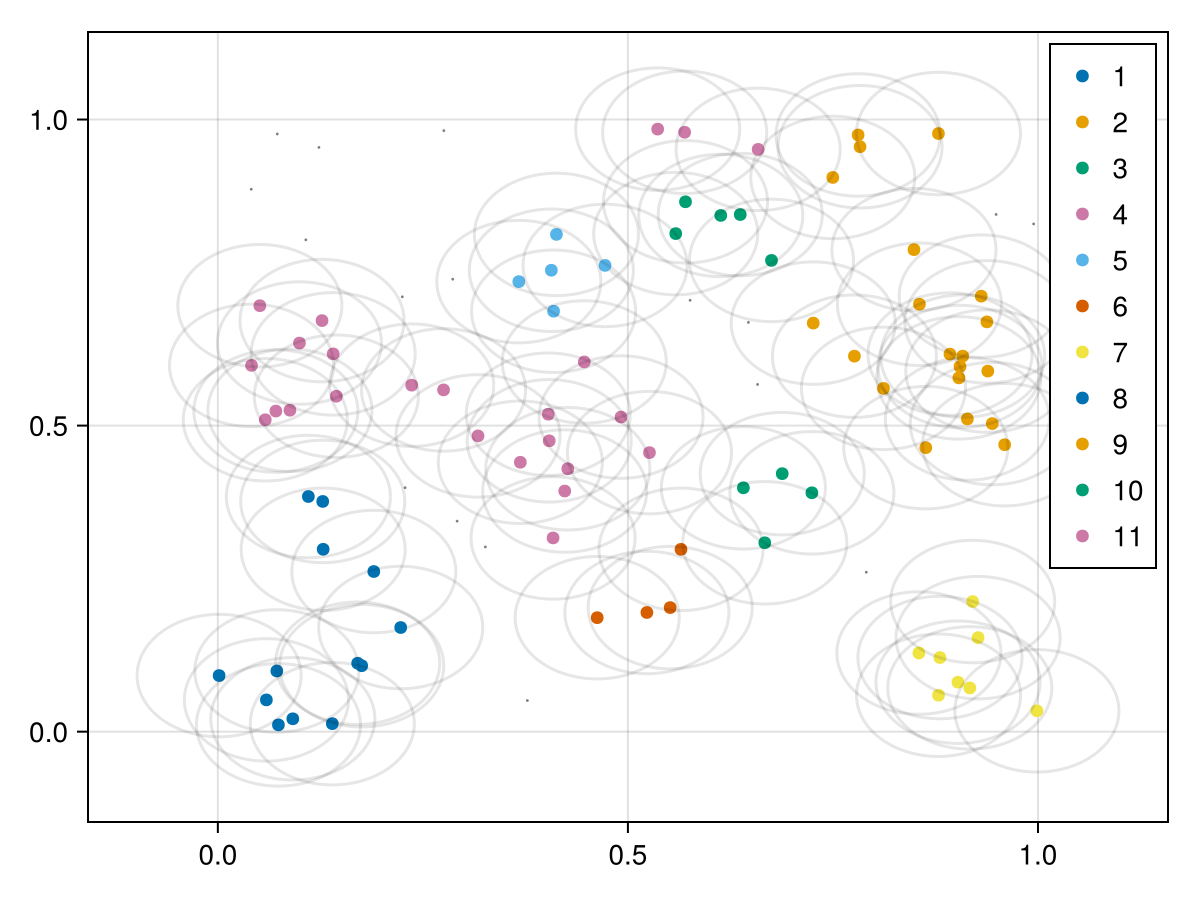

In [12]:
f = Figure()
ax = Axis(f[1, 1])

scatter!(points; color = :gray, markersize = 2.0)
for (id, cluster) in enumerate(clusters)
    scatter!(points[cluster], label = "$(id)")
    for (x0, y0) in points[cluster]
        draw_circle!(ax, x0, y0, cluster_radius)
    end
end
axislegend(ax)

f

In [16]:
# wrap timings in a function to avoid global variables causing problems
function run_tests(N; n_threads = 1)
    # times = zeros(N)
    times = []
    for i in 1:N
        points = rand(SVector{3, Float64}, 1_000_000)
        t0 = now()
        labels = dbscan.DBSCAN(points, 0.0005, 3, n_threads = n_threads)
        tf = now()
        push!(times, canonicalize(tf - t0))
    end
    return times
end

run_tests (generic function with 1 method)

In [17]:
times_1 = run_tests(10; n_threads = 1)

10-element Vector{Any}:
 1 second, 739 milliseconds
 1 second, 523 milliseconds
 1 second, 371 milliseconds
 1 second, 333 milliseconds
 1 second, 548 milliseconds
 1 second, 498 milliseconds
 1 second, 277 milliseconds
 1 second, 297 milliseconds
 1 second, 445 milliseconds
 1 second, 320 milliseconds

In [18]:
times_2 = run_tests(10; n_threads = 2)

10-element Vector{Any}:
 1 second, 92 milliseconds
 972 milliseconds
 1 second, 119 milliseconds
 935 milliseconds
 972 milliseconds
 919 milliseconds
 1 second, 4 milliseconds
 959 milliseconds
 1 second, 87 milliseconds
 982 milliseconds

In [19]:
times_4 = run_tests(10; n_threads = 4)

10-element Vector{Any}:
 781 milliseconds
 854 milliseconds
 948 milliseconds
 800 milliseconds
 973 milliseconds
 832 milliseconds
 968 milliseconds
 802 milliseconds
 787 milliseconds
 791 milliseconds

In [20]:
# smaller dataset for plotting